This notebook demonstrates the use of a python package called atommks towards analyzing nanoporous molecular structures.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
import numpy as np
import ase.io as aio
import scipy.io as sio
import matplotlib.pyplot as plt
import atommks.porosity as pore
import atommks.grid_generator as gen
from atommks.helpers import write2vtk
from toolz.curried import pipe, curry

In [3]:
def get_radii(atom_id, radius_type="vdw"):
    """
    atom_id: element symbol
    radius_type = "vdw" for Van der Waals or "cov" for Covalent
    """
    import pandas as pd
    
    xl = pd.ExcelFile("Elemental_Radii.xlsx")
    df = xl.parse(sheet_name=0, header = 2, index_col=1)
    
    if radius_type is "cov":
        key = 6
    elif radius_type is "vdw":
        key = 7
    else:
        raise ValueError("radius_type not supported")
    if atom_id in df.index:
        return df.loc[atom_id][key]
    else:
        raise ValueError("Elemental symbol not found")

## Load Structure of Interest

### For an amorphous hydrocarbon macromolecular structure

In [4]:
cif = "EFK_50A_0.80.xyz"
rep = [1, 1, 1]
fname = os.path.join("hydrocarbons", "EFK_50A_0.80.xyz")

### For a 3D bulk zeolite

In [5]:
cif = "MFI.cif"
fname = os.path.join("iza_zeolites", cif)
rep = [2]*3
# radii={"Si":1.35, "O": 1.35} # from the zeo++ paper

### Load the structure information using ase library as an atom object

In [6]:
atom = pipe(fname, 
            lambda fname: aio.read(fname), 
            lambda x: x.repeat(rep))

atom_ids = sorted(np.unique(atom.get_chemical_symbols()))

radii = {}
for idx in atom_ids:
    radii[idx] = get_radii(idx)

print("No. of atoms in the structure: %d" % len(atom))

No. of atoms in the structure: 2304


## Generate Voxelized Representation of the Pore Structure

In [7]:
%%time
len_pixel = 10
S, S_list, box_dim = gen.grid_maker(atom, len_pixel=len_pixel, atomic_radii=radii, full=False, fft=False)
print(S.shape)

(403, 396, 264)
CPU times: user 2.59 s, sys: 9.3 s, total: 11.9 s
Wall time: 12 s


### Compute Conventional Pore Metrics - PLD and LCD

```
distance grid computation time: 3.798s
PLD: 3.883
PLD computation time: 2.863s
LCD: 6.353
LCD computation time: 0.010s
```

In [8]:
strt = time.time()
padval = ((1, 1), (1, 1), (0, 0)) 
S_dgrid = pipe(S,
               lambda s: np.pad(s, padval, 'constant', constant_values=0),
               lambda s: pore.dgrid(s, len_pixel=len_pixel))
end = time.time()
print("distance grid computation time: %1.3fs"%(end-strt))

strt = time.time()
pld  = pore.get_pld(S_dgrid)
end  = time.time()
print("PLD: %1.3f" % pld)
print("PLD computation time: %1.3fs"%(end-strt))

strt = time.time()
lcd  = pore.get_lcd(S_dgrid)
end  = time.time()
print("LCD: %1.3f" % lcd)
print("LCD computation time: %1.3fs"%(end-strt))

distance grid computation time: 1.109s
PLD: 3.883
PLD computation time: 1.926s
LCD: 6.353
LCD computation time: 0.008s


### For PLD in a different direction

In [9]:
%%time
padval = ((1, 1), (1, 1), (0, 0)) 
pld = pipe(S, 
           lambda s: np.rot90(s, axes=(0,2)),
           lambda s: np.pad(s, padval, 'constant', constant_values=0),
           lambda s: pore.dgrid(s, len_pixel=len_pixel),
           lambda s: pore.get_pld(s))
print(pld)

4.3046875
CPU times: user 2.62 s, sys: 455 ms, total: 3.07 s
Wall time: 3.07 s


# Geometric and Statistical analysis of diffusion pathways

Compute the fraction of the void space within the molecular structure that is accessible to a probe molecule traversing in a particular direction

- Convert admissible coordinates to graph structure
 - generate adjacency matrix from graph structure
 - use adjacency matrix to identify shortest paths
 - use a Shortest Path heuristic on the adjacency matrix to prune the medial axis network of dead ends.
 - for the pruned path, use eculidean distance from nearest atoms at each path voxel as a metric of pore size distribution

### Extract pore volume accessible to a probe moleucle

In [10]:
strt = time.time()
padval = ((0, 0), (0, 0), (0, 0))
S_dgrid = pipe(S,
               lambda s: np.pad(s, padval, 'constant', constant_values=0),
               lambda s: pore.dgrid(s, len_pixel=len_pixel))
end = time.time()

strt = time.time()
S_1 = (pore.gen_cleanPore(S_dgrid, r_probe=1.0, r_min=2.5, len_pixel=len_pixel) > 0) * 1
end = time.time()
print("Pore Cleaning Computation Time: %1.3fs" % (end-strt))

Pore Cleaning Computation Time: 0.526s


```
%%time
# To generate vtk file of the accessible void region for visualization
write2vtk(S_1, "%s_pore.vtk" % cif)
```

In [11]:
%%time
# To generate vtk file of the accessible void region for visualization
write2vtk(S_1, "%s_pore.vtk" % cif)

CPU times: user 7.3 s, sys: 576 ms, total: 7.87 s
Wall time: 9.36 s


### Generate skeletonized representation of pore structure

```
Medial Path Computation Time: 13.179s
```

In [12]:
strt = time.time()
S_2 = pipe(S_1, 
           lambda x: np.pad(x, pad_width=((0,0),(0,0),(len_pixel, len_pixel)), mode = "constant", constant_values=1), 
           lambda x: pore.gen_medialAxis(x)[:,:,len_pixel:-len_pixel])
end = time.time()
print("Medial Path Computation Time: %1.3fs" % (end-strt))

Medial Path Computation Time: 9.635s


### Compute Shortest Paths connecting opposing faces of the molecular structure

```
Through Path Computation Time: 9.820s
Mean and setdev of path lengths: 3.606, 0.438
```

In [13]:
strt = time.time()
S_3, paths = pore.gen_throughPath(S_2, depth=1)
end = time.time()
print("Through Path Computation Time: %1.3fs" % (end-strt))
print("Mean and setdev of path lengths: %1.3f, %1.3f" % (np.mean(paths), np.std(paths)))

Through Path Computation Time: 8.822s
Mean and setdev of path lengths: 3.607, 0.438


In [14]:
n_channels = len(pore.return_labelled(S_1)[-1])
print("No. of unique channels: %d" % n_channels)

No. of unique channels: 1


In [15]:
%%time
# to generate vtk file of the medial path for visualization
write2vtk(S_3, "%s_through_path.vtk" % cif)

CPU times: user 7.12 s, sys: 496 ms, total: 7.61 s
Wall time: 8.81 s


### Compute accessible surface area and volume

In [16]:
asa = pore.get_asa(S_1, len_pixel=10)
print("Probe Accessible Surface Area: %1.3f" % asa)
av = np.count_nonzero(S_1) * (1 / len_pixel)**3
print("Probe Accessible Volume: %1.3f" % av)

Probe Accessible Surface Area: 10701.460
Probe Accessible Volume: 5401.031


### Compute pore size distribution

In [17]:
psd = S_dgrid[S_2==1]
print("Mean and setdev of pore size distribution: %1.3f, %1.3f" % (np.mean(psd), np.std(psd)))

Mean and setdev of pore size distribution: 2.051, 0.397


In [18]:
dim = np.asarray(S.shape) / len_pixel
print("dimensions of the structure: ", dim)

dimensions of the structure:  [40.3 39.6 26.4]


### Visualize path length distribution (length in angstrom)

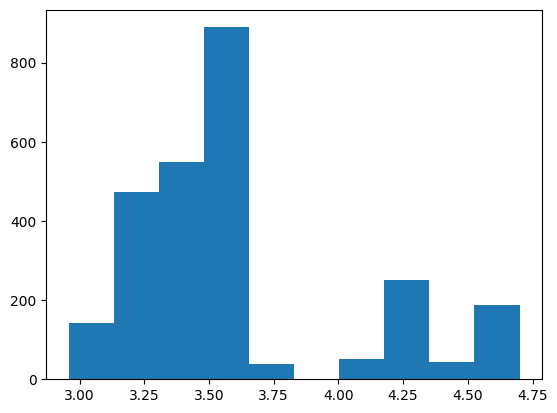

In [19]:
plt.hist(paths)
plt.show()

### Visualize pore size distribution (length in angstrom)

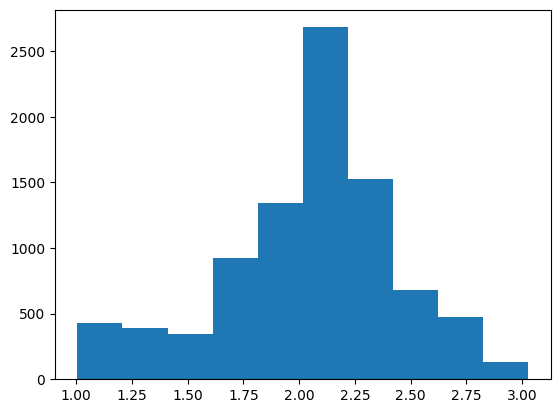

In [20]:
plt.hist(psd)
plt.show()

In [21]:
import pandas as pd
pore_data_df = pd.read_csv("iza_bulk.csv", header = 0, sep = ",", on_bad_lines='skip', index_col="cif")
pore_data_df.head(3)

# def get_pore_data(material_id: str):
#     """
#     material_id: IZA framework code
#     """



#     return pore_data_df.loc[material_id]

,Unnamed: 0,pld,lcd,asa,av,psd mean,psd std,n_paths,paths mean,paths std,xdim,ydim,zdim,n_channels
cif,,,,,,,,,,,,,,
ABW,0,2.476562,4.242640,2824.94,1546.396,0.994927,0.524161,589.0,1.690595,0.268248,18.5,9.5,16.8,1.0
ACO,1,3.601562,4.604346,5859.62,3399.968,1.090194,0.590122,550.0,1.732020,0.351302,18.6,18.6,18.4,1.0
AEI,2,3.601562,7.337575,19212.96,15170.100,1.418122,0.816693,2376.0,1.444696,0.115261,26.2,25.6,36.9,1.0


In [22]:
def get_pore_data(material_id: str):
    """
    material_id: IZA framework code
    """
    import pandas as pd
    pore_data_df = pd.read_csv("iza_bulk.csv", header = 0, sep = ",", on_bad_lines='skip', index_col="cif")

    if material_id in pore_data_df.index:
        row = pore_data_df.loc[material_id]
        return row.to_dict()
    else:
        raise ValueError("Material ID not found")
    
material_id = "ABW"
pore_data = get_pore_data(material_id)
print(f"PLD: {pore_data['pld']}, LCD: {pore_data['lcd']}, ASA: {pore_data['asa']}, AV: {pore_data['av']}, PSD: {pore_data['psd mean']}")

PLD: 2.4765625, LCD: 4.242640495300293, ASA: 2824.9400000000005, AV: 1546.3960000000004, PSD: 0.9949274063110352


In [23]:
material_id in pore_data_df.index

True